# Figure 3 - Feedback Weights

May 15, 2022

This code has been organized after a long meeting with James on Sunday, May 15

The goal here is to show that the metric works for various scales of driving feedback weights Wfb.

#### Part 1 - Scale Driving Feedback, train with RFLO

#### Part 2 - Scale Driving Feedback, train with REINFORCE

In [27]:
pwd

'/Users/jacobportes/Documents/Code/rnn-learning/experiments/NeurIPS-2022-4-29'

In [28]:
folder = 'figures-2022-5-16/'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator,FixedFormatter
import matplotlib.pylab as pylab

# analysis
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.linear_model import LinearRegression
from scipy import interpolate # don't import stats
from scipy import linalg as LA
from scipy.ndimage.filters import uniform_filter1d

# miscellaneous
from tqdm import tqdm
from itertools import cycle
from copy import deepcopy
import pickle

import logging
import warnings
import dataclasses
from dataclasses import dataclass
from typing import Optional, List

import sys
sys.path.append("../..")

In [3]:
from rnn import RNNparams, RNN
from task import Task
from simulation import Simulation
from algorithms.bptt import BPTT
from algorithms.rflo import RFLO
from algorithms.reinforce import REINFORCE
from algorithms.track_vars import TrackVars
from algorithms.weight_mirror import WeightMirror

from utils.plotting import plot_trained_trajectories, paper_format
from utils.metric import cos_sim, return_norm_and_angle
from utils.functions import choose_aligned_matrix

from utils.metric import cos_sim, flow_field_data, flow_field_predicted, calculate_flow_field_correlation


In [4]:
trial_duration = 20
n_in=4
frac_on = 0.2

x_tonic = 0.0*np.ones((trial_duration, n_in)) # shape 20 x 4 i.e. time x channel
x_pulse1 = x_tonic.copy()
x_pulse2 = x_tonic.copy()
x_pulse3 = x_tonic.copy()
x_pulse4 = x_tonic.copy()
x_pulse1[0:int(trial_duration*frac_on),0] = 1
x_pulse2[0:int(trial_duration*frac_on),1] = 1
x_pulse3[0:int(trial_duration*frac_on),2] = 1
x_pulse4[0:int(trial_duration*frac_on),3] = 1

task1 = Task(x_in=x_pulse1,y_target=np.asarray([[1],[1]]))
task2 = Task(x_in=x_pulse2,y_target=np.asarray([[-1],[1]]))
task3 = Task(x_in=x_pulse3,y_target=np.asarray([[1],[-1]]))
task4 = Task(x_in=x_pulse4,y_target=np.asarray([[-1],[-1]]))

# Learning in Recurrent Weights, with strong feedback

1. We choose $W^{bmi1}$ with respect to $W^{fb}$

```
""" w_out1 is chosen wrt w_fb and m (w_fb==w_m for simplicity) """
w_out1 = choose_aligned_matrix(net0.w_fb.copy().T,n_change=n_changes_w_out0,overlap=overlap_w_out0,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)
```

2. Scale $W^{fb}$, but not $M$

```
net1 = RNN(params)
net1.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy(),w_fb = scale*net0.w_fb.copy())
net1.set_weights(w_out = w_out1)
net1.set_weights(w_m = net0.w_fb.copy()) # don't scale w_m...this would effectively scale the learning rate
```

6it [00:00, 56.93it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.1
sig_out: 0.01
tau_rec: 10
dt: 1.0
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2
driving_feedback: True
eta_fb: 0.1
sig_fb: 0.01
feedback_signal: position
velocity_transform: False
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7fb730f39630>


3000it [00:33, 90.63it/s]
12it [00:00, 115.04it/s]

>> SCALE 0.01
M norm: 2.82	 M angle: 0.49, 1 iterations
w_out1 norm: 2.29	 w_out vs. w_out1 angle: 0.20
w_m norm: 2.82	 w_out1 vs. w_m angle: 0.49
w_m norm: 3.14	 w_out vs. w_m angle: 0.30

500it [00:04, 122.89it/s]
5000it [00:53, 92.64it/s]
500it [00:04, 123.57it/s]


AR early fit 0.945, late fit 0.950


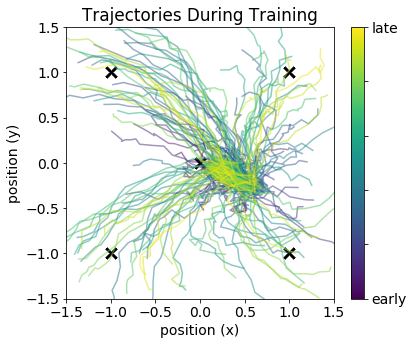

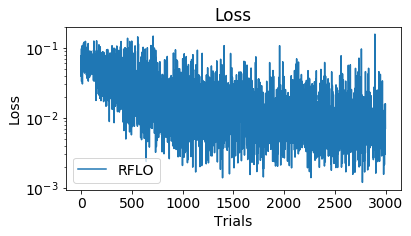

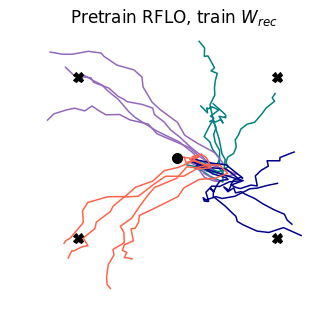

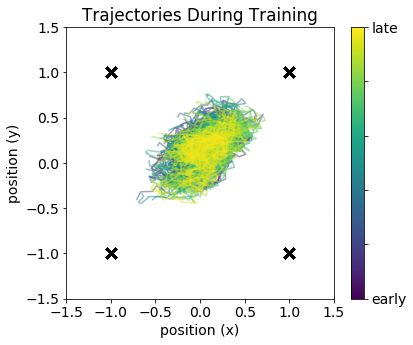

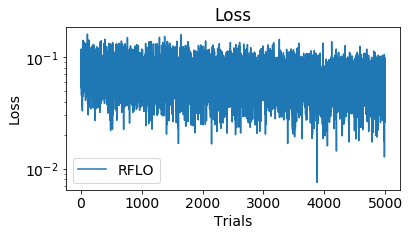

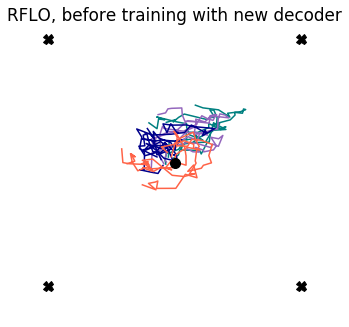

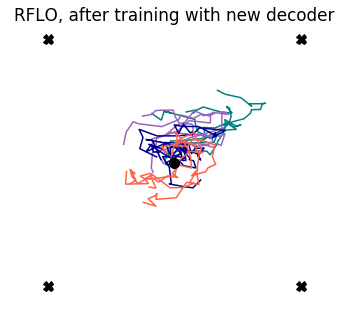

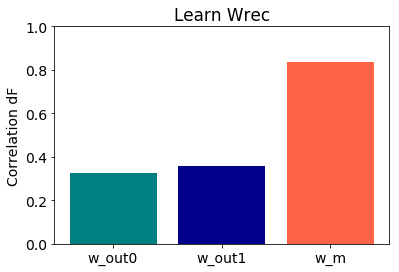

12it [00:00, 119.77it/s]

>> SCALE 1
M norm: 2.82	 M angle: 0.49, 1 iterations
w_out1 norm: 2.29	 w_out vs. w_out1 angle: 0.20
w_m norm: 2.82	 w_out1 vs. w_m angle: 0.49
w_m norm: 3.14	 w_out vs. w_m angle: 0.30

500it [00:03, 126.09it/s]
5000it [00:53, 93.12it/s]
500it [00:04, 114.73it/s]


AR early fit 0.953, late fit 0.986


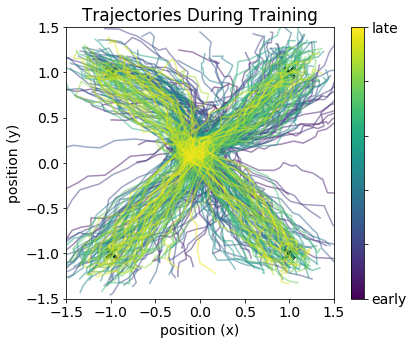

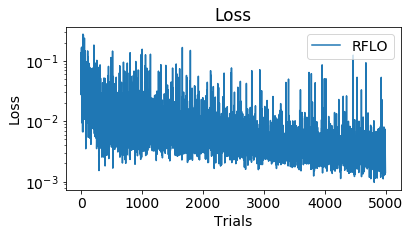

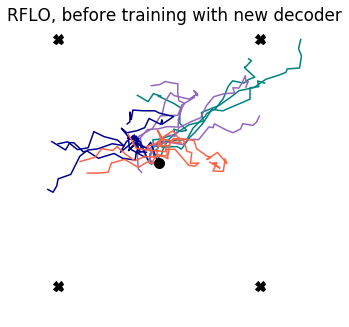

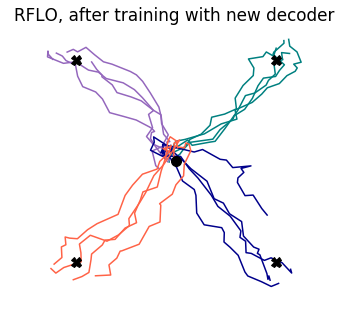

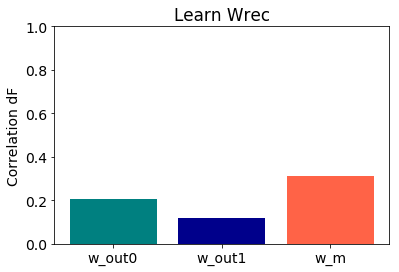

12it [00:00, 119.96it/s]

>> SCALE 5
M norm: 2.82	 M angle: 0.49, 1 iterations
w_out1 norm: 2.29	 w_out vs. w_out1 angle: 0.20
w_m norm: 2.82	 w_out1 vs. w_m angle: 0.49
w_m norm: 3.14	 w_out vs. w_m angle: 0.30

500it [00:03, 125.81it/s]
5000it [00:52, 95.30it/s]
500it [00:03, 126.09it/s]


AR early fit 0.989, late fit 0.992


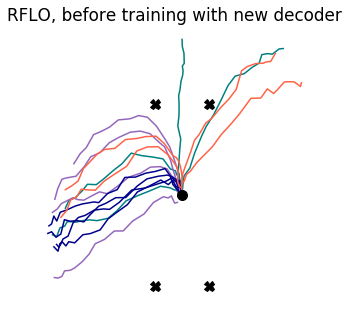

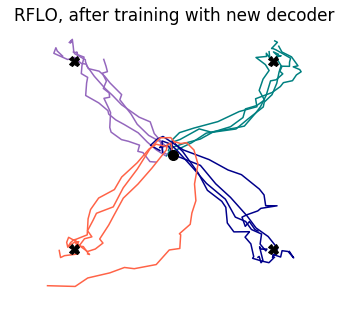

12it [00:00, 117.57it/s]

>> SCALE 10
M norm: 2.82	 M angle: 0.49, 1 iterations
w_out1 norm: 2.29	 w_out vs. w_out1 angle: 0.20
w_m norm: 2.82	 w_out1 vs. w_m angle: 0.49
w_m norm: 3.14	 w_out vs. w_m angle: 0.30

500it [00:03, 125.17it/s]
5000it [00:54, 91.62it/s]
500it [00:04, 121.70it/s]


AR early fit 0.990, late fit 0.992


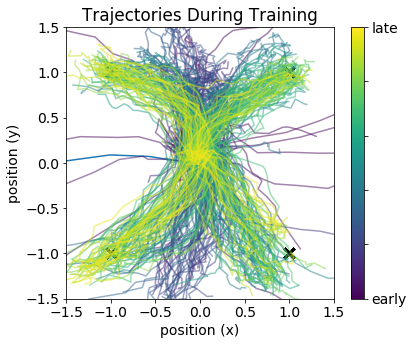

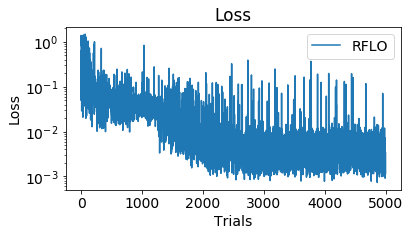

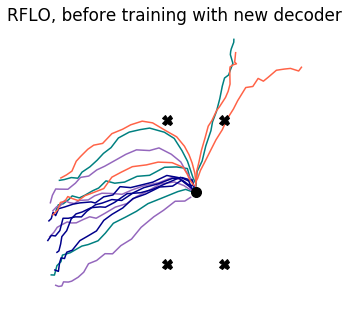

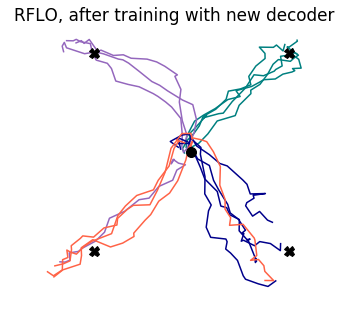

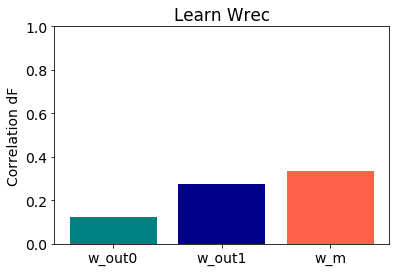

12it [00:00, 115.01it/s]

>> SCALE 0.01
M norm: 2.81	 M angle: 0.50, 16 iterations
w_out1 norm: 2.28	 w_out vs. w_out1 angle: 0.19
w_m norm: 2.81	 w_out1 vs. w_m angle: 0.50
w_m norm: 3.14	 w_out vs. w_m angle: 0.30

500it [00:03, 125.13it/s]
5000it [00:52, 95.66it/s]
500it [00:04, 120.26it/s]


AR early fit 0.945, late fit 0.950


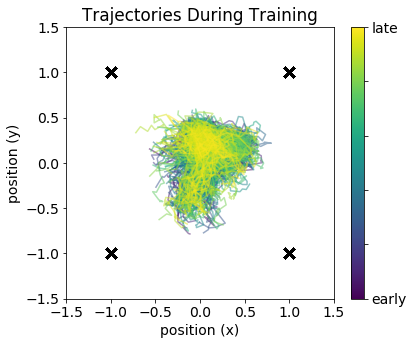

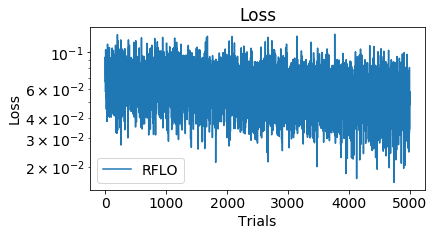

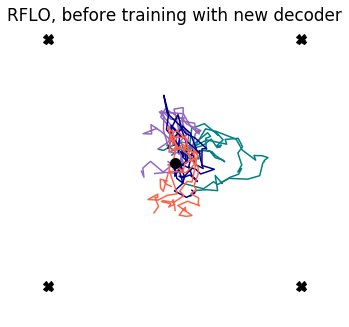

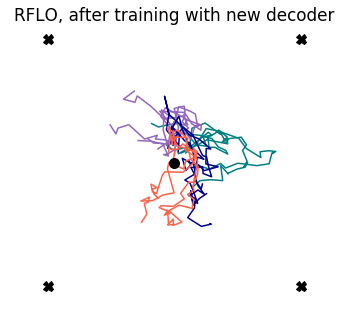

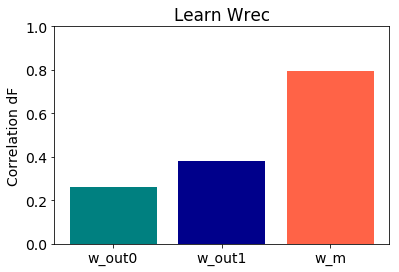

11it [00:00, 106.96it/s]

>> SCALE 1
M norm: 2.81	 M angle: 0.50, 16 iterations
w_out1 norm: 2.28	 w_out vs. w_out1 angle: 0.19
w_m norm: 2.81	 w_out1 vs. w_m angle: 0.50
w_m norm: 3.14	 w_out vs. w_m angle: 0.30

500it [00:03, 125.46it/s]
5000it [00:53, 92.80it/s]
500it [00:04, 122.98it/s]


AR early fit 0.959, late fit 0.986


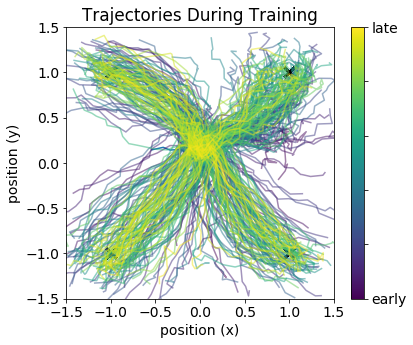

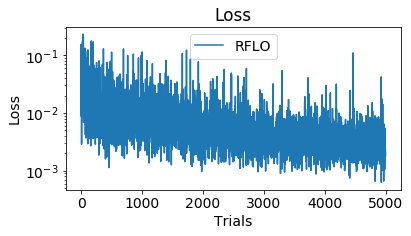

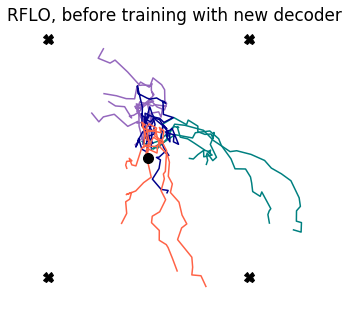

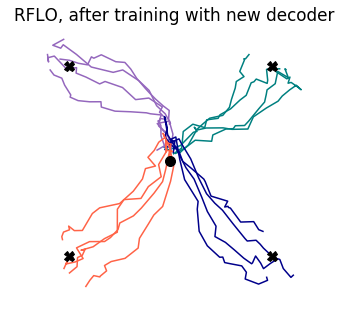

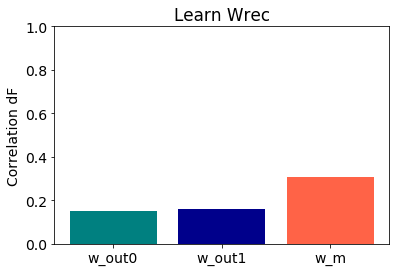

11it [00:00, 108.95it/s]

>> SCALE 5
M norm: 2.81	 M angle: 0.50, 16 iterations
w_out1 norm: 2.28	 w_out vs. w_out1 angle: 0.19
w_m norm: 2.81	 w_out1 vs. w_m angle: 0.50
w_m norm: 3.14	 w_out vs. w_m angle: 0.30

500it [00:03, 125.44it/s]
5000it [00:56, 88.95it/s]
500it [00:03, 126.14it/s]


AR early fit 0.987, late fit 0.993


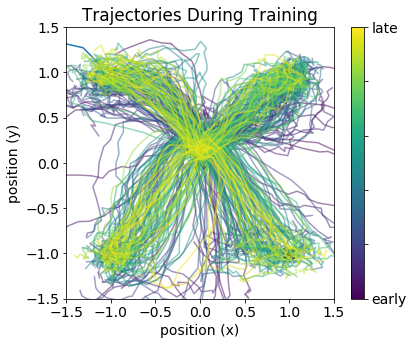

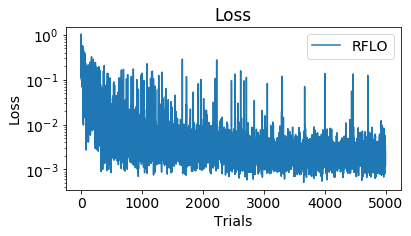

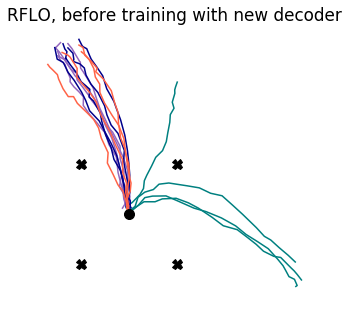

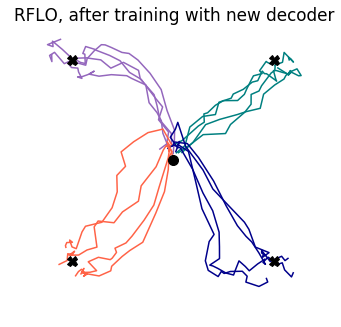

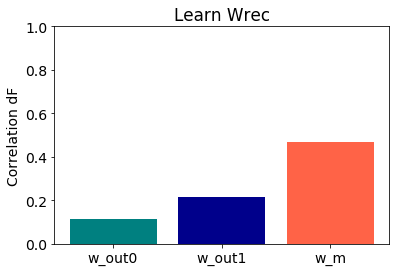

12it [00:00, 116.20it/s]

>> SCALE 10
M norm: 2.81	 M angle: 0.50, 16 iterations
w_out1 norm: 2.28	 w_out vs. w_out1 angle: 0.19
w_m norm: 2.81	 w_out1 vs. w_m angle: 0.50
w_m norm: 3.14	 w_out vs. w_m angle: 0.30

500it [00:04, 120.78it/s]
5000it [00:56, 87.88it/s]
500it [00:04, 113.84it/s]


AR early fit 0.989, late fit 0.992


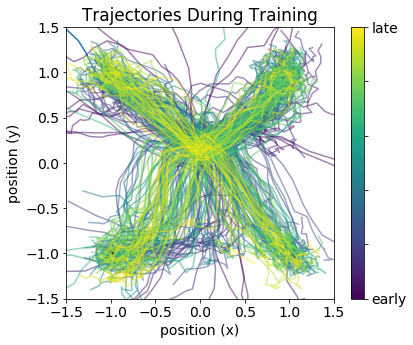

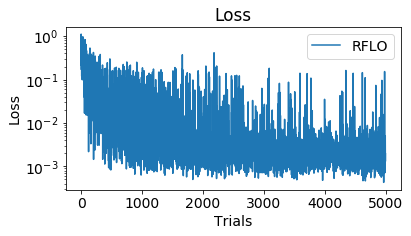

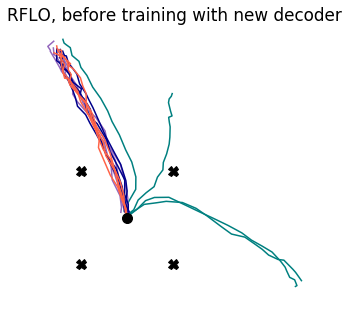

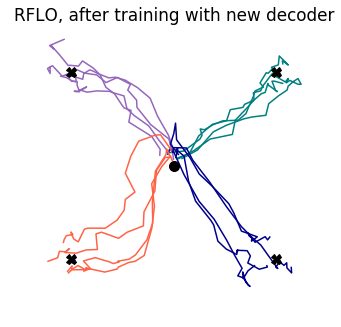

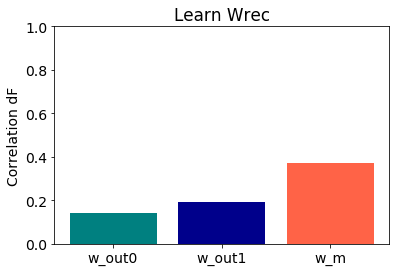

10it [00:00, 94.64it/s]

>> SCALE 0.01
M norm: 2.82	 M angle: 0.49, 56 iterations
w_out1 norm: 2.16	 w_out vs. w_out1 angle: 0.31
w_m norm: 2.82	 w_out1 vs. w_m angle: 0.49
w_m norm: 3.14	 w_out vs. w_m angle: 0.30

500it [00:04, 118.20it/s]
5000it [01:15, 66.40it/s]
500it [00:06, 78.26it/s]


AR early fit 0.945, late fit 0.949


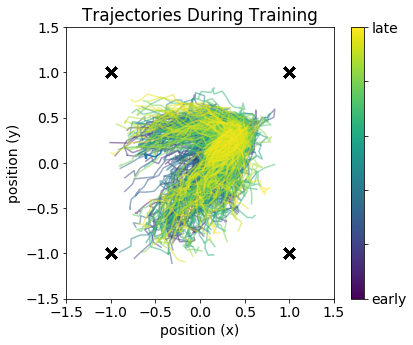

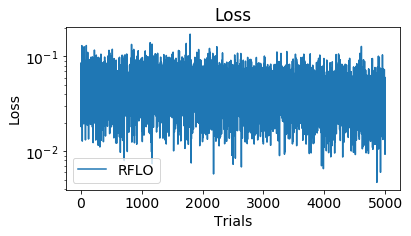

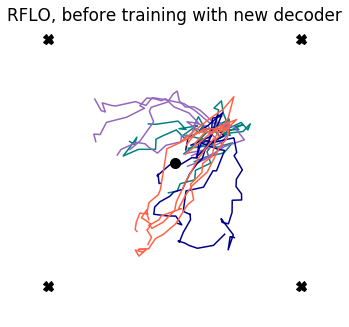

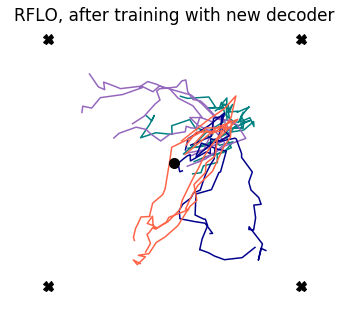

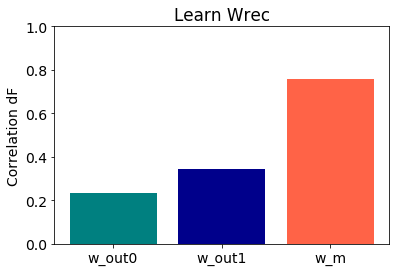

6it [00:00, 55.50it/s]

>> SCALE 1
M norm: 2.82	 M angle: 0.49, 56 iterations
w_out1 norm: 2.16	 w_out vs. w_out1 angle: 0.31
w_m norm: 2.82	 w_out1 vs. w_m angle: 0.49
w_m norm: 3.14	 w_out vs. w_m angle: 0.30

500it [00:13, 37.61it/s]
5000it [01:22, 60.28it/s]
500it [00:03, 125.94it/s]


AR early fit 0.958, late fit 0.981


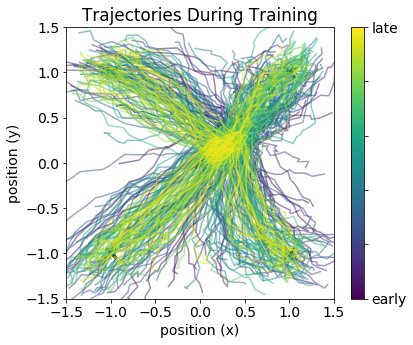

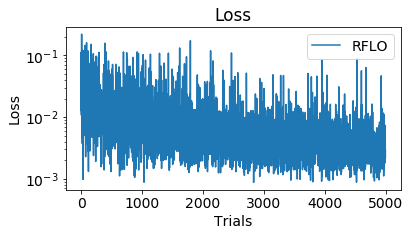

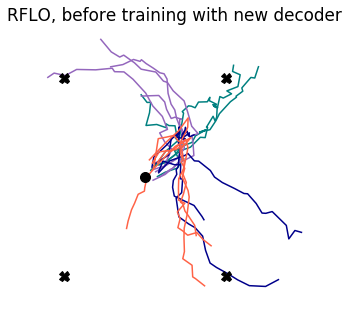

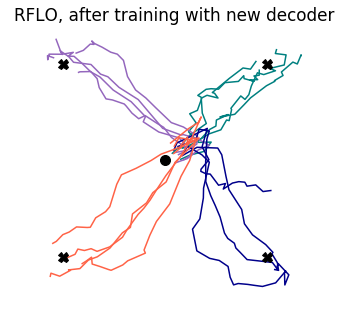

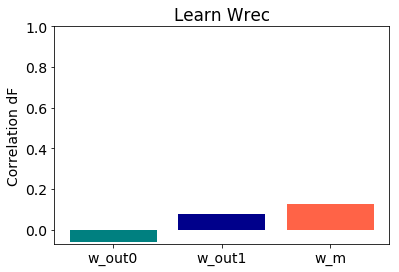

7it [00:00, 69.16it/s]

>> SCALE 5
M norm: 2.82	 M angle: 0.49, 56 iterations
w_out1 norm: 2.16	 w_out vs. w_out1 angle: 0.31
w_m norm: 2.82	 w_out1 vs. w_m angle: 0.49
w_m norm: 3.14	 w_out vs. w_m angle: 0.30

500it [00:04, 117.80it/s]
5000it [00:53, 92.63it/s]
500it [00:04, 119.77it/s]


AR early fit 0.979, late fit 0.990


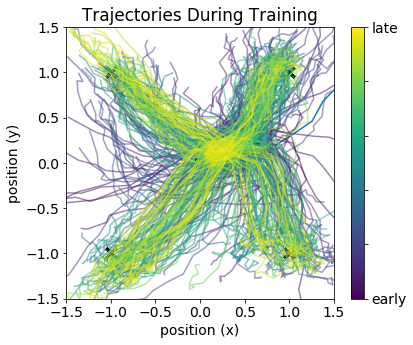

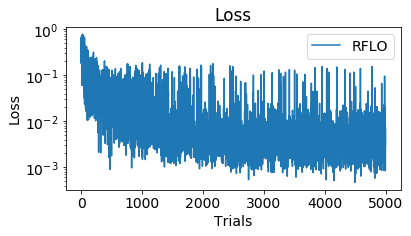

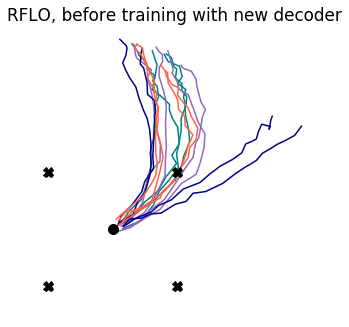

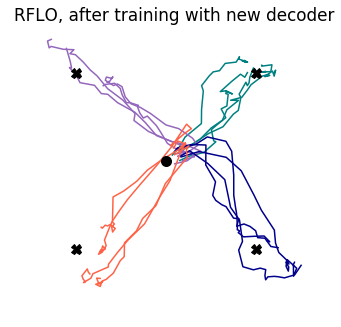

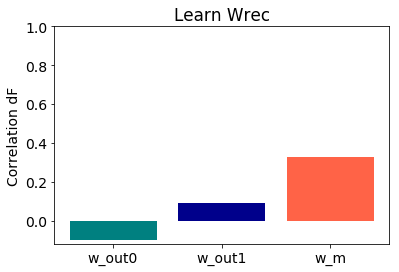

10it [00:00, 98.44it/s]

>> SCALE 10
M norm: 2.82	 M angle: 0.49, 56 iterations
w_out1 norm: 2.16	 w_out vs. w_out1 angle: 0.31
w_m norm: 2.82	 w_out1 vs. w_m angle: 0.49
w_m norm: 3.14	 w_out vs. w_m angle: 0.30

500it [00:03, 125.42it/s]
5000it [00:55, 90.38it/s]
500it [00:04, 121.88it/s]


AR early fit 0.982, late fit 0.987


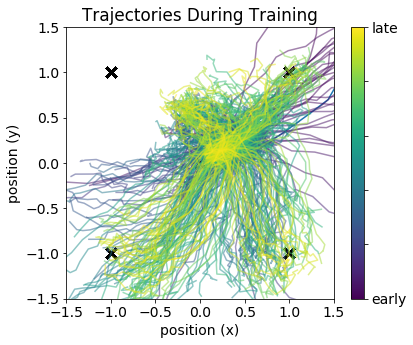

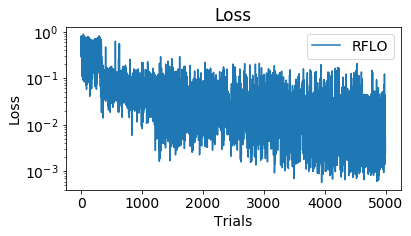

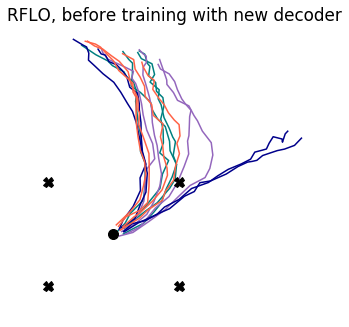

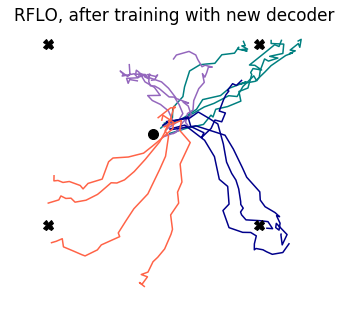

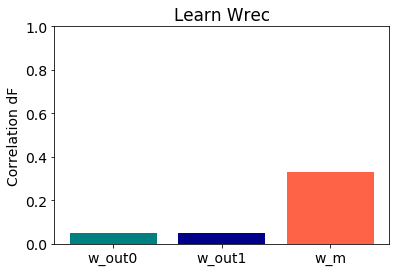

In [6]:
# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=10,
               eta_in=0.1,eta_rec=0.1,eta_out=0.1,eta_fb=0.1,g_fb=2,
               sig_in=0.0,sig_rec=0.1,sig_out=0.01,sig_fb=0.01,
               velocity_transform=False, tau_vel = 0.8, dt_vel = 0.1,
               driving_feedback=True,
               rng=np.random.RandomState(72))
params.print_params()

# Initialize RNN
net0 = RNN(params)
sim0 = Simulation(net0)
rflo = RFLO(net0,apply_to=['w_rec','w_fb'],online=False)
sim0.run_session(n_trials=3000, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['loss'], plot=True, plot_freq=20)

fig0 = plot_trained_trajectories(sim=sim0, tasks=[task1,task2,task3,task4],title='Pretrain RFLO, train '+r'$W_{rec}$')






""" Average over multiple seeds """
seeds = [1776,1812,1918]#,33,47,91,73,444,567,886,212]#,72,81,1973,1978,2002]
overlap = 0.5
n_change = 60
overlap_w_out0 = 0.5
n_changes_w_out0 = 60
scales_w_fb = [0.01,1,5,10]
training_duration = 5000


stats = {}
stats['corr1'] = []
stats['corr2'] = []
stats['corr3'] = []

stats['corrcoef'] = []

stats['corr_w_fb_w_m'] = []
stats['corr_w_fb_w_out'] = []

for seed in seeds:

    corr1_list = []
    corr2_list = []
    corr3_list = []

    corrcoef_list = []
    
    corr_w_fb_w_m = []
    corr_w_fb_w_out = []

    #for overlap,n_change in zip(overlaps,n_changes):
    """ loop over strength of w_fb """
    for scale in scales_w_fb:
        print('>> SCALE {}'.format(scale))
        
        """ w_out1 is chosen wrt w_fb and m (w_fb==w_m for simplicity) """
        w_out1 = choose_aligned_matrix(net0.w_fb.copy().T,n_change=n_changes_w_out0,overlap=overlap_w_out0,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)
        #w_m = choose_aligned_matrix(w_out1,n_change=n_change,overlap=overlap,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)

        w_m = net0.w_fb.copy().T
        
        # confirm overlap between w_out1 and w_out
        norm, angle = return_norm_and_angle(net0.w_out,w_out1)
        print('\nw_out1 norm: {:.2f}'.format(norm) + '\t w_out vs. w_out1 angle: {:.2f}'.format(angle),end='')

        # confirm overlap between w_out1 and w_m
        norm, angle = return_norm_and_angle(w_out1,w_m)
        print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out1 vs. w_m angle: {:.2f}'.format(angle),end='')

        # confirm overlap between w_out and w_m
        norm, angle = return_norm_and_angle(net0.w_out,w_m)
        print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out vs. w_m angle: {:.2f}'.format(angle),end='')
        
        
        
        
        net1_pre = RNN(params)
        net1_pre.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy(),w_fb = scale*net0.w_fb.copy())
        net1_pre.set_weights(w_out = w_out1)
        net1_pre.set_weights(w_m = scale*net0.w_fb.copy())

        # unfortunately I need to make a different network to maintain integrity of pre and post simulations for plotting
        net1 = RNN(params)
        net1.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy(),w_fb = scale*net0.w_fb.copy())
        net1.set_weights(w_out = w_out1)
        net1.set_weights(w_m = net0.w_fb.copy()) # don't scale w_m...this would effectively scale the learning rate




        """ Track activity with new decoder, before training """

        sim1_pre = Simulation(net1_pre)
        trackvars = TrackVars(net1_pre,apply_to=[]) 
        sim1_pre.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)
        #fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1,task2,task3,task4],title='RFLO, before training with new decoder')

        
        corr_w_fb_w_m.append(np.corrcoef(net1_pre.w_fb.copy().ravel(),net1_pre.w_m.copy().ravel())[0,1]) # w_fb and w_m both have dimensions (n_rec, n_out)
        corr_w_fb_w_out.append(np.corrcoef(net1_pre.w_fb.copy().ravel(),net1_pre.w_out.T.copy().ravel())[0,1]) # w_fb and w_m both have dimensions (n_rec, n_out)

        
        """ Train with new decoder """

        sim1_train = Simulation(net1)
        rflo = RFLO(net1,apply_to=['w_rec'],online=False)
        sim1_train.run_session(n_trials=training_duration, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['h','loss','err','pos'], plot=True, plot_freq=10)

        """ Track activity with new decoder, after training """
        net1_post = RNN(params)
        net1_post.set_weights(w_in=net1.w_in.copy(), w_rec=net1.w_rec.copy(),w_fb = scale*net0.w_fb.copy())
        net1_post.set_weights(w_out = net1.w_out)
        net1_post.set_weights(w_m = scale*net0.w_fb.copy())

        sim1_post = Simulation(net1_post)
        trackvars = TrackVars(net1_post,apply_to=[]) 
        sim1_post.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)

        
        fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1,task2,task3,task4],title='RFLO, before training with new decoder')

        fig = plot_trained_trajectories(sim=sim1_post, tasks=[task1,task2,task3,task4],title='RFLO, after training with new decoder')
        
        
        """ Calculate F fields """
        F_early, score_early = flow_field_data(sim1_pre.session_probes['h'])
        F_late, score_late = flow_field_data(sim1_post.session_probes['h'])

        print('AR early fit {:.3f}, late fit {:.3f}'.format(score_early,score_late))

        Fdata = F_late - F_early

        # separate train and test data from sim1_train
        n_total = len(sim1_train.session_probes['h'])
        n_train = int(0.5 * n_total)
        idx_train = np.random.RandomState(1975+seed).choice(np.arange(0,n_total),size=n_train,replace=False).astype(int)
        idx_test = np.arange(0,n_total)[~idx_train].astype(int)
        #idx_test=idx_train

        h_train = np.asarray(sim1_train.session_probes['h'])[idx_train,:,:,:]
        err_train = np.asarray(sim1_train.session_probes['err'])[idx_train,:,:,:]
        pos_train = np.asarray(sim1_train.session_probes['pos'])[idx_train,:,:,:]

        
        Fpred_w_out = flow_field_predicted(net0.w_out,err_train,h_train)
        Fpred_w_out1 = flow_field_predicted(w_out1,err_train,h_train)
        Fpred_w_m = flow_field_predicted(w_m,err_train,h_train)
        

        h_test = np.asarray(sim1_train.session_probes['h'])[idx_test,:,:,:]

        corr1 = calculate_flow_field_correlation(Fpred_w_out,Fdata,h_test) # could also sample sim_test
        corr1_list.append(corr1)

        corr2 = calculate_flow_field_correlation(Fpred_w_out1,Fdata,h_test) # could also sample sim_test
        corr2_list.append(corr2)

        corr3 = calculate_flow_field_correlation(Fpred_w_m,Fdata,h_test) # could also sample sim_test
        corr3_list.append(corr3)
        

        
        # correlation after learning
        corr_w_fb_w_m.append(np.corrcoef(net1.w_fb.copy().ravel(),net1.w_m.copy().ravel())[0,1]) # w_fb and w_m both have dimensions (n_rec, n_out)
        corr_w_fb_w_out.append(np.corrcoef(net1.w_fb.copy().ravel(),net1.w_out.T.copy().ravel())[0,1]) # w_fb and w_m both have dimensions (n_rec, n_out)

        
        fig,ax = plt.subplots(1,1)
       
        plt.bar([0,1,2],[corr1,corr2,corr3],tick_label=['w_out0','w_out1','w_m'],color=['teal','darkblue','tomato'])

        plt.ylim(top=1)
        plt.ylabel('Correlation dF')
        plt.title('Learn Wrec')
        plt.show()
        
        
        
        
        
    # update
    stats['corr1'].append(corr1_list)
    stats['corr2'].append(corr2_list)
    stats['corr3'].append(corr3_list)

    #stats['corrcoef'].append(corrcoef_list)

    
    stats['corr_w_fb_w_m'].append(corr_w_fb_w_m)
    stats['corr_w_fb_w_out'].append(corr_w_fb_w_out)


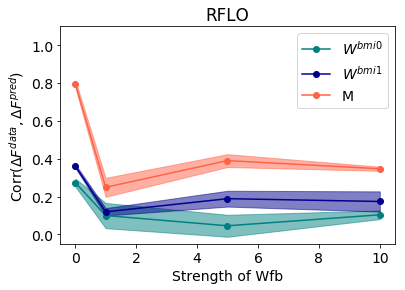

In [10]:
""" Plot scaling of W_fb"""

save = False
paper = False

x = scales_w_fb
n_samples = np.asarray(stats['corr1']).shape[0]
mn1 = np.mean(np.asarray(stats['corr1']).T,axis=1)
mn2 = np.mean(np.asarray(stats['corr2']).T,axis=1)
mn3 = np.mean(np.asarray(stats['corr3']).T,axis=1)
std1 = np.std(np.asarray(stats['corr1']).T,axis=1)
std2 = np.std(np.asarray(stats['corr2']).T,axis=1)
std3 = np.std(np.asarray(stats['corr3']).T,axis=1)
sem1 = np.std(np.asarray(stats['corr1']).T,axis=1)/np.sqrt(n_samples)
sem2 = np.std(np.asarray(stats['corr2']).T,axis=1)/np.sqrt(n_samples)
sem3 = np.std(np.asarray(stats['corr3']).T,axis=1)/np.sqrt(n_samples)

fig,ax = plt.subplots(1,1)


plt.plot(x,mn1,'o-',color='teal',label=r'$W^{bmi0}$')
plt.plot(x,mn2,'o-',color='darkblue',label=r'$W^{bmi1}$')
plt.plot(x,mn3,'o-',color='tomato',label='M')
plt.fill_between(x,mn1-sem1,mn1+sem1,alpha=0.5,color='teal')
plt.fill_between(x,mn2-sem2,mn2+sem2,alpha=0.5,color='darkblue')
plt.fill_between(x,mn3-sem3,mn3+sem3,alpha=0.5,color='tomato')



plt.title('RFLO')
plt.ylabel('Corr('+r'$\Delta F^{data},\Delta F^{pred})$')
plt.xlabel('Strength of Wfb')
plt.ylim([-0.05,1.1])
#plt.xlim([-50,1400])
plt.legend()

if paper:
    fig,ax = paper_format(fig=fig,ax=ax,xlabels=None,ylabels=[0,0.2,0.4,0.6,0.8,1],linewidth=2,ylim=[-0.05,1],figsize=(2.25,3))

plt.show()

if save:
    fig.savefig(folder+'rflo-scale_w_fb.pdf')

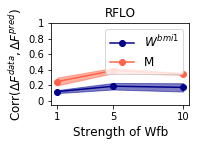

In [16]:
""" Plot scaling of W_fb"""

save = True
paper = True

x = scales_w_fb
n_samples = np.asarray(stats['corr1']).shape[0]
mn2 = np.mean(np.asarray(stats['corr2']).T,axis=1)
mn3 = np.mean(np.asarray(stats['corr3']).T,axis=1)
std2 = np.std(np.asarray(stats['corr2']).T,axis=1)
std3 = np.std(np.asarray(stats['corr3']).T,axis=1)
sem2 = np.std(np.asarray(stats['corr2']).T,axis=1)/np.sqrt(n_samples)
sem3 = np.std(np.asarray(stats['corr3']).T,axis=1)/np.sqrt(n_samples)

fig,ax = plt.subplots(1,1)


plt.plot(x[1:],mn2[1:],'o-',color='darkblue',label=r'$W^{bmi1}$')
plt.plot(x[1:],mn3[1:],'o-',color='tomato',label='M')
plt.fill_between(x[1:],mn2[1:]-sem2[1:],mn2[1:]+sem2[1:],alpha=0.5,color='darkblue')
plt.fill_between(x[1:],mn3[1:]-sem3[1:],mn3[1:]+sem3[1:],alpha=0.5,color='tomato')



plt.title('RFLO')
plt.ylabel('Corr('+r'$\Delta F^{data},\Delta F^{pred})$')
plt.xlabel('Strength of Wfb')
plt.ylim([-0.05,1.1])
#plt.xlim([-50,1400])
plt.legend()

if paper:
    fig,ax = paper_format(fig=fig,ax=ax,xlabels=[1,5,10],ylabels=[0,0.2,0.4,0.6,0.8,1],linewidth=2,ylim=[-0.05,1],figsize=(2.25,3))

plt.show()

if save:
    fig.savefig(folder+'rflo-scale_w_fb.pdf')

# Scale Driving Feedback - REINFORCE

4it [00:00, 37.81it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.1
sig_out: 0.01
tau_rec: 10
dt: 1.0
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.25
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2
driving_feedback: True
eta_fb: 0.1
sig_fb: 0.01
feedback_signal: position
velocity_transform: False
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7fb733a98798>


3000it [00:38, 77.10it/s]
13it [00:00, 125.81it/s]

>> SCALE 1
M norm: 2.82	 M angle: 0.49, 1 iterations
w_out1 norm: 2.29	 w_out vs. w_out1 angle: 0.20
w_m norm: 2.82	 w_out1 vs. w_m angle: 0.49
w_m norm: 3.14	 w_out vs. w_m angle: 0.30

500it [00:04, 113.54it/s]
10000it [02:26, 68.14it/s]
500it [00:05, 83.70it/s]


AR early fit 0.953, late fit 0.975


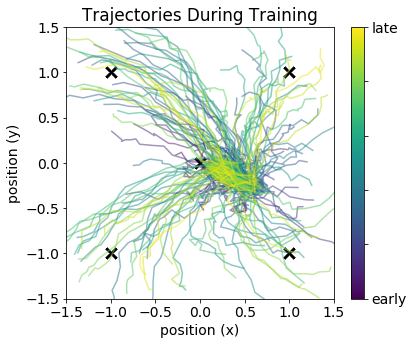

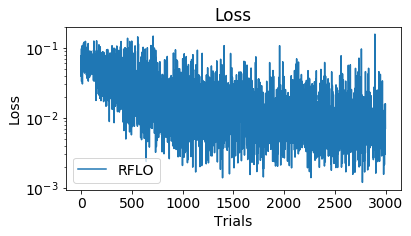

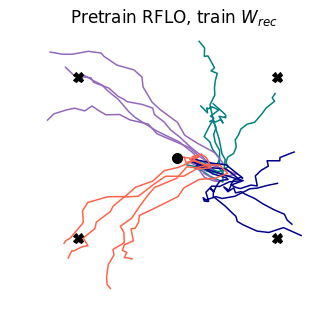

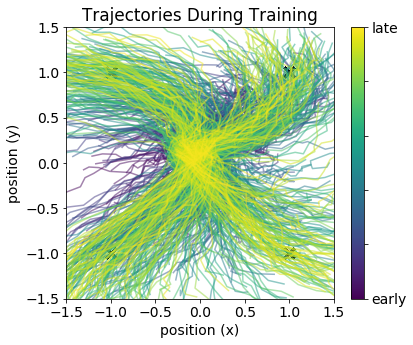

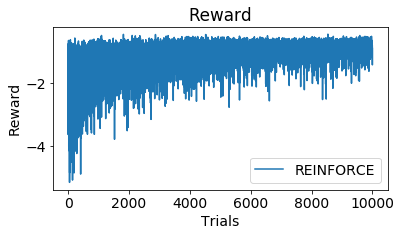

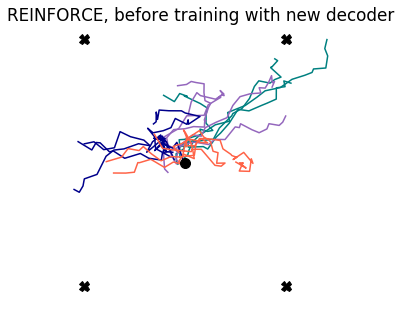

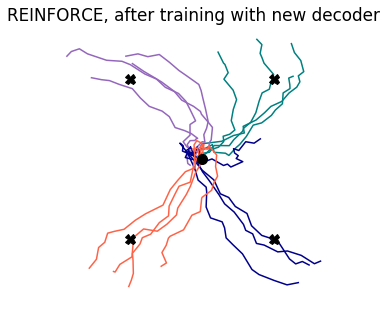

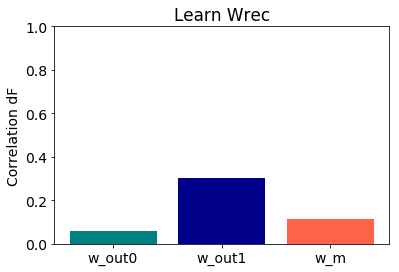

13it [00:00, 125.83it/s]

>> SCALE 2
M norm: 2.82	 M angle: 0.49, 1 iterations
w_out1 norm: 2.29	 w_out vs. w_out1 angle: 0.20
w_m norm: 2.82	 w_out1 vs. w_m angle: 0.49
w_m norm: 3.14	 w_out vs. w_m angle: 0.30

500it [00:04, 116.84it/s]
10000it [02:16, 76.77it/s]
500it [00:04, 120.87it/s]


AR early fit 0.974, late fit 0.983


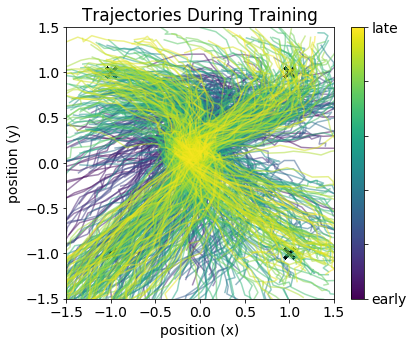

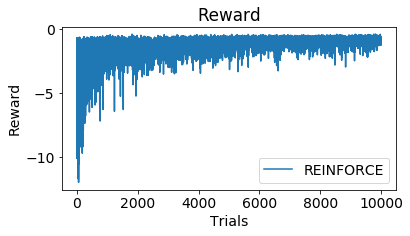

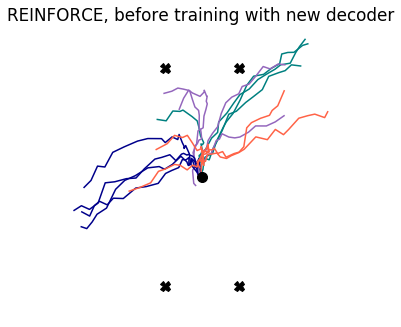

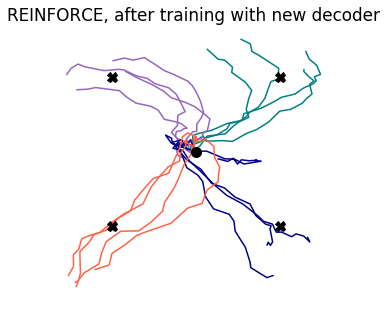

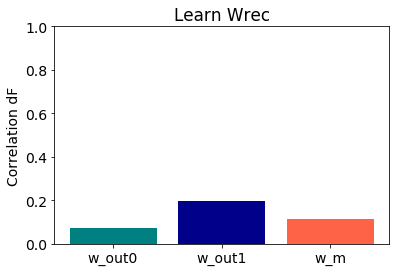

12it [00:00, 118.60it/s]

>> SCALE 5
M norm: 2.82	 M angle: 0.49, 1 iterations
w_out1 norm: 2.29	 w_out vs. w_out1 angle: 0.20
w_m norm: 2.82	 w_out1 vs. w_m angle: 0.49
w_m norm: 3.14	 w_out vs. w_m angle: 0.30

500it [00:05, 96.75it/s] 
10000it [02:10, 76.52it/s]
500it [00:06, 81.26it/s]


AR early fit 0.989, late fit 0.983


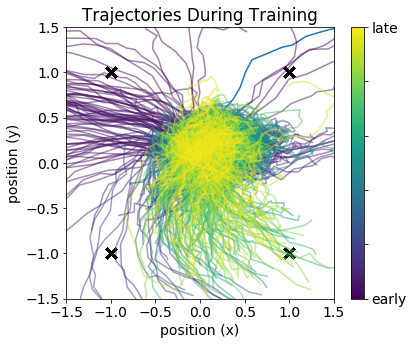

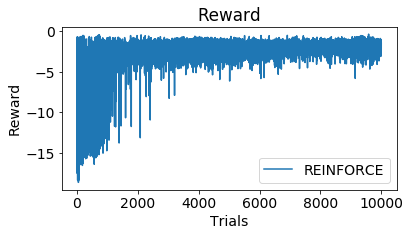

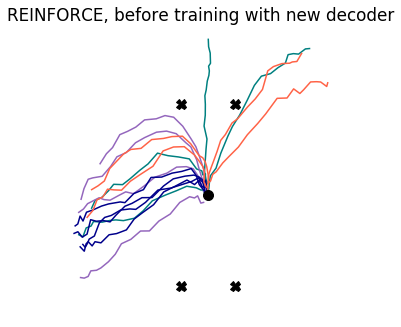

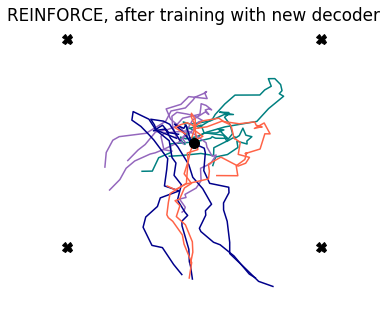

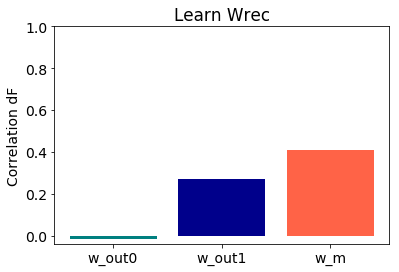

8it [00:00, 75.40it/s]

>> SCALE 1
M norm: 2.81	 M angle: 0.50, 16 iterations
w_out1 norm: 2.28	 w_out vs. w_out1 angle: 0.19
w_m norm: 2.81	 w_out1 vs. w_m angle: 0.50
w_m norm: 3.14	 w_out vs. w_m angle: 0.30

500it [00:05, 89.81it/s] 
10000it [02:10, 76.76it/s]
500it [00:04, 108.23it/s]


AR early fit 0.959, late fit 0.978


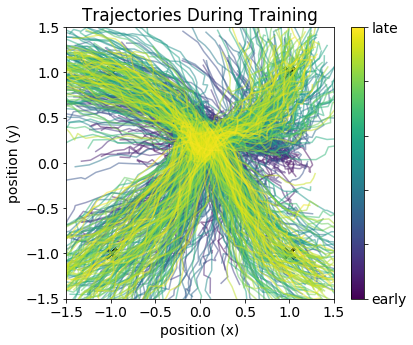

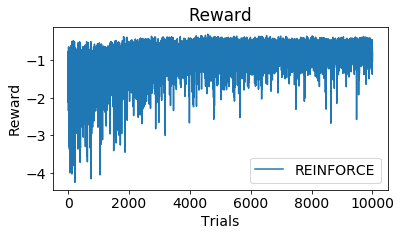

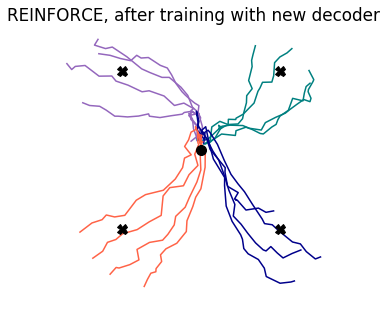

10it [00:00, 93.90it/s]

>> SCALE 2
M norm: 2.81	 M angle: 0.50, 16 iterations
w_out1 norm: 2.28	 w_out vs. w_out1 angle: 0.19
w_m norm: 2.81	 w_out1 vs. w_m angle: 0.50
w_m norm: 3.14	 w_out vs. w_m angle: 0.30

500it [00:04, 108.98it/s]
10000it [02:01, 82.06it/s]
500it [00:04, 109.44it/s]


AR early fit 0.976, late fit 0.983


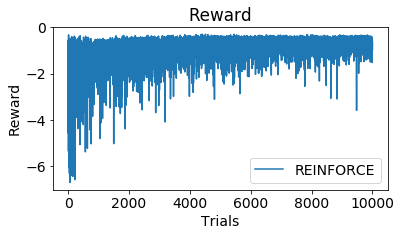

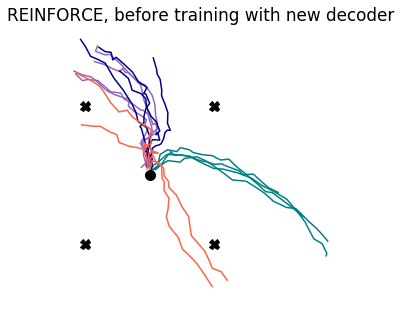

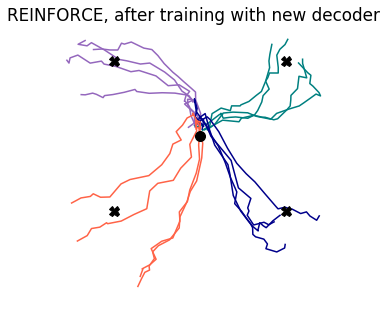

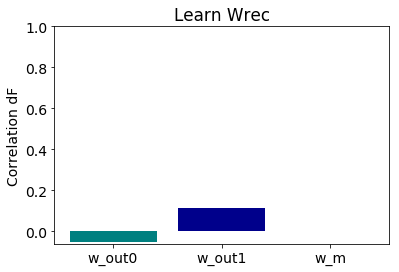

11it [00:00, 105.15it/s]

>> SCALE 5
M norm: 2.81	 M angle: 0.50, 16 iterations
w_out1 norm: 2.28	 w_out vs. w_out1 angle: 0.19
w_m norm: 2.81	 w_out1 vs. w_m angle: 0.50
w_m norm: 3.14	 w_out vs. w_m angle: 0.30

500it [00:04, 109.53it/s]
10000it [02:21, 70.44it/s]
500it [00:05, 87.03it/s]


AR early fit 0.987, late fit 0.989


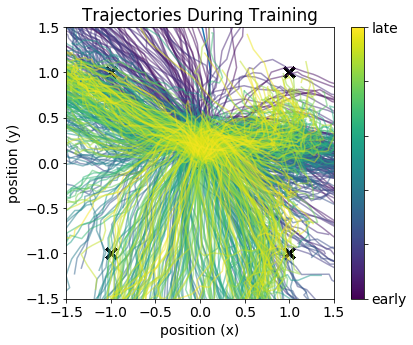

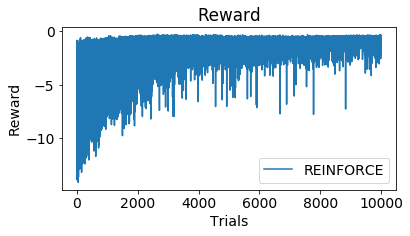

10it [00:00, 95.00it/s]

>> SCALE 1
M norm: 2.82	 M angle: 0.49, 56 iterations
w_out1 norm: 2.16	 w_out vs. w_out1 angle: 0.31
w_m norm: 2.82	 w_out1 vs. w_m angle: 0.49
w_m norm: 3.14	 w_out vs. w_m angle: 0.30

500it [00:05, 90.45it/s]
10000it [02:19, 71.60it/s]
500it [00:04, 103.69it/s]


AR early fit 0.958, late fit 0.974


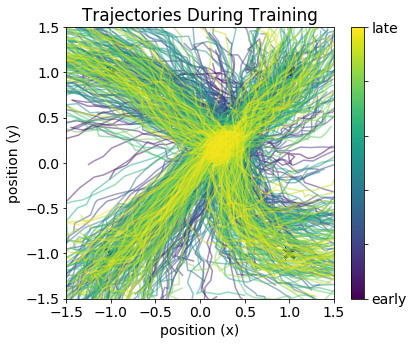

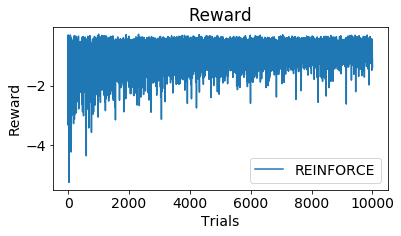

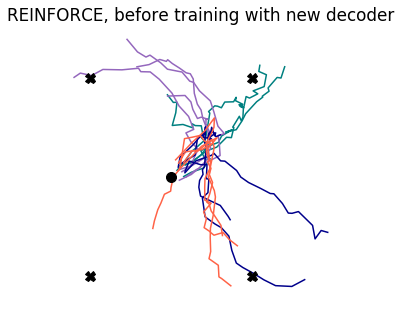

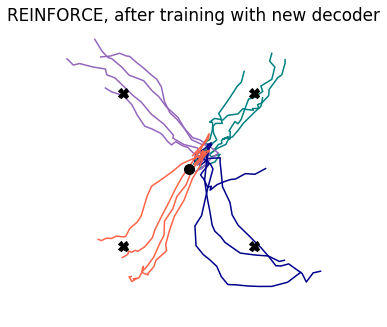

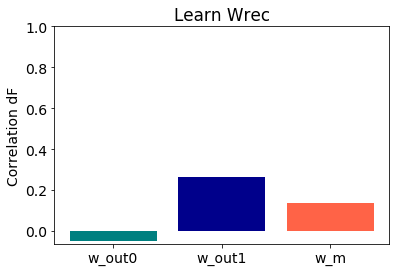

12it [00:00, 114.27it/s]

>> SCALE 2
M norm: 2.82	 M angle: 0.49, 56 iterations
w_out1 norm: 2.16	 w_out vs. w_out1 angle: 0.31
w_m norm: 2.82	 w_out1 vs. w_m angle: 0.49
w_m norm: 3.14	 w_out vs. w_m angle: 0.30

500it [00:04, 103.09it/s]
10000it [02:12, 75.33it/s]
500it [00:04, 124.44it/s]


AR early fit 0.968, late fit 0.981


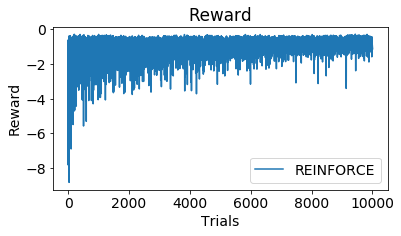

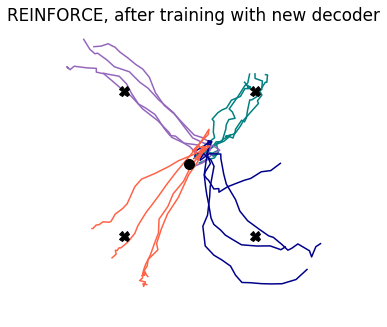

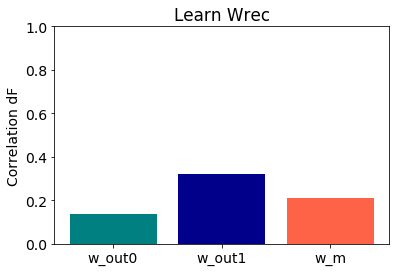

10it [00:00, 99.68it/s]

>> SCALE 5
M norm: 2.82	 M angle: 0.49, 56 iterations
w_out1 norm: 2.16	 w_out vs. w_out1 angle: 0.31
w_m norm: 2.82	 w_out1 vs. w_m angle: 0.49
w_m norm: 3.14	 w_out vs. w_m angle: 0.30

500it [00:04, 124.66it/s]
10000it [01:57, 85.24it/s]
500it [00:04, 120.62it/s]


AR early fit 0.979, late fit 0.984


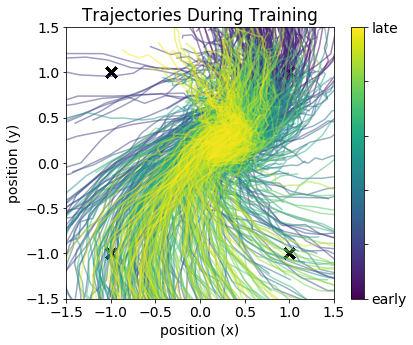

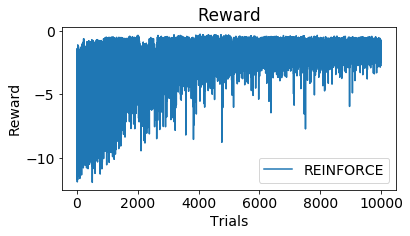

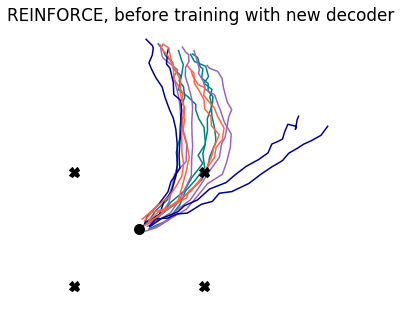

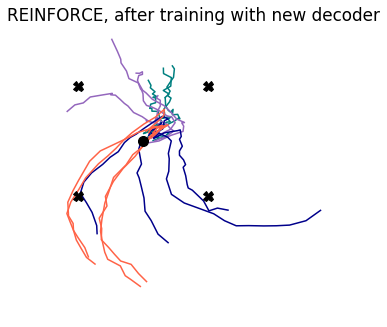

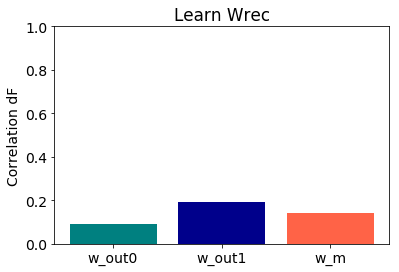

In [21]:
# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=10,
               eta_in=0.1,eta_rec=0.1,eta_out=0.25,eta_fb=0.1,g_fb=2,
               sig_in=0.0,sig_rec=0.1,sig_out=0.01,sig_fb=0.01,
               velocity_transform=False, tau_vel = 0.8, dt_vel = 0.1,
               driving_feedback=True,
               rng=np.random.RandomState(72))
params.print_params()

# Initialize RNN
net0 = RNN(params)
sim0 = Simulation(net0)
rflo = RFLO(net0,apply_to=['w_rec','w_fb'],online=False)
sim0.run_session(n_trials=3000, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['loss'], plot=True, plot_freq=20)

fig0 = plot_trained_trajectories(sim=sim0, tasks=[task1,task2,task3,task4],title='Pretrain RFLO, train '+r'$W_{rec}$')






""" Average over multiple seeds """
seeds = [1776,1812,1918]#,33,47,91,73,444,567,886,212]#,72,81,1973,1978,2002]
overlap = 0.5
n_change = 60
overlap_w_out0 = 0.5
n_changes_w_out0 = 60
scales_w_fb = [1,2,5]
training_duration = 10000


stats = {}
stats['corr1'] = []
stats['corr2'] = []
stats['corr3'] = []

stats['corrcoef'] = []

stats['corr_w_fb_w_m'] = []
stats['corr_w_fb_w_out'] = []

for seed in seeds:

    corr1_list = []
    corr2_list = []
    corr3_list = []

    corrcoef_list = []
    
    corr_w_fb_w_m = []
    corr_w_fb_w_out = []

    #for overlap,n_change in zip(overlaps,n_changes):
    """ loop over strength of w_fb """
    for scale in scales_w_fb:
        print('>> SCALE {}'.format(scale))
        
        """ w_out1 is chosen wrt w_fb and m (w_fb==w_m for simplicity) """
        w_out1 = choose_aligned_matrix(net0.w_fb.copy().T,n_change=n_changes_w_out0,overlap=overlap_w_out0,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)
        #w_m = choose_aligned_matrix(w_out1,n_change=n_change,overlap=overlap,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)

        w_m = net0.w_fb.copy().T
        
        # confirm overlap between w_out1 and w_out
        norm, angle = return_norm_and_angle(net0.w_out,w_out1)
        print('\nw_out1 norm: {:.2f}'.format(norm) + '\t w_out vs. w_out1 angle: {:.2f}'.format(angle),end='')

        # confirm overlap between w_out1 and w_m
        norm, angle = return_norm_and_angle(w_out1,w_m)
        print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out1 vs. w_m angle: {:.2f}'.format(angle),end='')

        # confirm overlap between w_out and w_m
        norm, angle = return_norm_and_angle(net0.w_out,w_m)
        print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out vs. w_m angle: {:.2f}'.format(angle),end='')
        
        
        
        
        net1_pre = RNN(params)
        net1_pre.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy(),w_fb = scale*net0.w_fb.copy())
        net1_pre.set_weights(w_out = w_out1)
        net1_pre.set_weights(w_m = scale*net0.w_fb.copy())

        # unfortunately I need to make a different network to maintain integrity of pre and post simulations for plotting
        net1 = RNN(params)
        net1.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy(),w_fb = scale*net0.w_fb.copy())
        net1.set_weights(w_out = w_out1)
        net1.set_weights(w_m = scale*net0.w_fb.copy())




        """ Track activity with new decoder, before training """

        sim1_pre = Simulation(net1_pre)
        trackvars = TrackVars(net1_pre,apply_to=[]) 
        sim1_pre.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)
        #fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1,task2,task3,task4],title='RFLO, before training with new decoder')

        
        corr_w_fb_w_m.append(np.corrcoef(net1_pre.w_fb.copy().ravel(),net1_pre.w_m.copy().ravel())[0,1]) # w_fb and w_m both have dimensions (n_rec, n_out)
        corr_w_fb_w_out.append(np.corrcoef(net1_pre.w_fb.copy().ravel(),net1_pre.w_out.T.copy().ravel())[0,1]) # w_fb and w_m both have dimensions (n_rec, n_out)

        
        """ Train with new decoder """

        sim1_train = Simulation(net1)
        #rflo = RFLO(net1,apply_to=['w_rec'],online=False)
        reinforce = REINFORCE(net1,apply_to=['w_rec'],online=False,tau_reward=5)
        sim1_train.run_session(n_trials=training_duration, tasks=[task1,task2,task3,task4], learn_alg=[reinforce], probe_types=['h','reward','err','pos'], plot=True, plot_freq=10)

        """ Track activity with new decoder, after training """
        net1_post = RNN(params)
        net1_post.set_weights(w_in=net1.w_in.copy(), w_rec=net1.w_rec.copy(),w_fb = scale*net0.w_fb.copy())
        net1_post.set_weights(w_out = net1.w_out)
        net1_post.set_weights(w_m = scale*net0.w_fb.copy())

        sim1_post = Simulation(net1_post)
        trackvars = TrackVars(net1_post,apply_to=[]) 
        sim1_post.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)

        
        fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1,task2,task3,task4],title='REINFORCE, before training with new decoder')

        fig = plot_trained_trajectories(sim=sim1_post, tasks=[task1,task2,task3,task4],title='REINFORCE, after training with new decoder')
        
        
        """ Calculate F fields """
        F_early, score_early = flow_field_data(sim1_pre.session_probes['h'])
        F_late, score_late = flow_field_data(sim1_post.session_probes['h'])

        print('AR early fit {:.3f}, late fit {:.3f}'.format(score_early,score_late))

        Fdata = F_late - F_early

        # separate train and test data from sim1_train
        n_total = len(sim1_train.session_probes['h'])
        n_train = int(0.5 * n_total)
        idx_train = np.random.RandomState(1975+seed).choice(np.arange(0,n_total),size=n_train,replace=False).astype(int)
        idx_test = np.arange(0,n_total)[~idx_train].astype(int)
        #idx_test=idx_train

        h_train = np.asarray(sim1_train.session_probes['h'])[idx_train,:,:,:]
        err_train = np.asarray(sim1_train.session_probes['err'])[idx_train,:,:,:]
        pos_train = np.asarray(sim1_train.session_probes['pos'])[idx_train,:,:,:]

        
        Fpred_w_out = flow_field_predicted(net0.w_out,err_train,h_train)
        Fpred_w_out1 = flow_field_predicted(w_out1,err_train,h_train)
        Fpred_w_m = flow_field_predicted(w_m,err_train,h_train)
        

        h_test = np.asarray(sim1_train.session_probes['h'])[idx_test,:,:,:]

        corr1 = calculate_flow_field_correlation(Fpred_w_out,Fdata,h_test) # could also sample sim_test
        corr1_list.append(corr1)

        corr2 = calculate_flow_field_correlation(Fpred_w_out1,Fdata,h_test) # could also sample sim_test
        corr2_list.append(corr2)

        corr3 = calculate_flow_field_correlation(Fpred_w_m,Fdata,h_test) # could also sample sim_test
        corr3_list.append(corr3)
        

        
        # correlation after learning
        corr_w_fb_w_m.append(np.corrcoef(net1.w_fb.copy().ravel(),net1.w_m.copy().ravel())[0,1]) # w_fb and w_m both have dimensions (n_rec, n_out)
        corr_w_fb_w_out.append(np.corrcoef(net1.w_fb.copy().ravel(),net1.w_out.T.copy().ravel())[0,1]) # w_fb and w_m both have dimensions (n_rec, n_out)

        
        fig,ax = plt.subplots(1,1)
       
        plt.bar([0,1,2],[corr1,corr2,corr3],tick_label=['w_out0','w_out1','w_m'],color=['teal','darkblue','tomato'])

        plt.ylim(top=1)
        plt.ylabel('Correlation dF')
        plt.title('Learn Wrec')
        plt.show()
        
        
        
        
        
    # update
    stats['corr1'].append(corr1_list)
    stats['corr2'].append(corr2_list)
    stats['corr3'].append(corr3_list)

    #stats['corrcoef'].append(corrcoef_list)

    
    stats['corr_w_fb_w_m'].append(corr_w_fb_w_m)
    stats['corr_w_fb_w_out'].append(corr_w_fb_w_out)


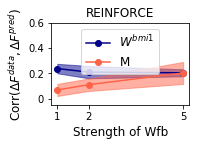

In [26]:
""" Plot scaling of W_fb"""

save = True
paper = True

x = scales_w_fb
n_samples = np.asarray(stats['corr1']).shape[0]
mn2 = np.mean(np.asarray(stats['corr2']).T,axis=1)
mn3 = np.mean(np.asarray(stats['corr3']).T,axis=1)
std2 = np.std(np.asarray(stats['corr2']).T,axis=1)
std3 = np.std(np.asarray(stats['corr3']).T,axis=1)
sem2 = np.std(np.asarray(stats['corr2']).T,axis=1)/np.sqrt(n_samples)
sem3 = np.std(np.asarray(stats['corr3']).T,axis=1)/np.sqrt(n_samples)

fig,ax = plt.subplots(1,1)


plt.plot(x,mn2,'o-',color='darkblue',label=r'$W^{bmi1}$')
plt.plot(x,mn3,'o-',color='tomato',label='M')
plt.fill_between(x,mn2-sem2,mn2+sem2,alpha=0.5,color='darkblue')
plt.fill_between(x,mn3-sem3,mn3+sem3,alpha=0.5,color='tomato')



plt.title('REINFORCE')
plt.ylabel('Corr('+r'$\Delta F^{data},\Delta F^{pred})$')
plt.xlabel('Strength of Wfb')
plt.ylim([-0.05,1.1])
#plt.xlim([-50,1400])
plt.legend()

if paper:
    fig,ax = paper_format(fig=fig,ax=ax,xlabels=[1,2,5],ylabels=[0,0.2,0.4,0.6],linewidth=2,ylim=[-0.05,0.6],figsize=(2.25,3))

plt.show()

if save:
    fig.savefig(folder+'reinforce-scale_w_fb.pdf')